In [25]:
from gpax.probing import probabilistic_probe
import torch
from pathlib import Path
import json
import itertools
import torchvision
import sklearn

In [26]:
config = dict(
    use_gpu=True,
    dataset_root='.//datasets',
    dataset_name='fashion_brands_looks',
    set_img_num = 3,
    checkpoint_name = "resnet18",

    # checkpoint_name='imagenet',
    num_inducing = 100, #[100,200,300,400,500,600,700,800], #100
    latent_dim = 10, #[5,10,15,20,25,30,35,40,45,50], #10
    model_name='MultitaskDirichletGPModel', #MultitaskDirichletGPModel DirichletGPModel MeanFieldDecoupledModel MAPApproximateGP OrthDecoupledApproximateGP
    train_fc=True,
    num_epochs=50,
    learning_rate=0.01,
)

In [27]:
dataset_root = config['dataset_root']
dataset_name = config['dataset_name']
num_inducing = config['num_inducing']
latent_dim = config['latent_dim']
num_epochs = config['num_epochs']
model_name = config['model_name']
checkpoint_name = config['checkpoint_name']
use_gpu = config['use_gpu']
learning_rate = config['learning_rate']
train_fc = config['train_fc']
set_img_num = config['set_img_num']
img_root = dataset_root + "//"+dataset_name
print(img_root)



assert not use_gpu or torch.cuda.is_available(), 'GPU must be available if `use_gpu` is True'

.//datasets//fashion_brands_looks


## load dataset

In [28]:
# Load dataset
torch.manual_seed(0)
device = torch.device('cuda:0' if use_gpu else 'cpu')

embedding_path = Path('.//fashion_gp//embeddings/') / dataset_name / checkpoint_name

dataset_path = Path(dataset_root) / dataset_name
train_metadata = json.loads((dataset_path / 'train.json').read_text())
test_metadata = json.loads((dataset_path / 'test.json').read_text())
# test_metadata = json.loads((dataset_path / 'brands_testing.json').read_text()) 
val_metadata = json.loads((dataset_path / 'val.json').read_text())

n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)

n_classes = 1 + max(meta['label'] for meta in itertools.chain(train_metadata, test_metadata, val_metadata))

train_classes = torch.as_tensor([meta['label'] for meta in train_metadata], dtype=torch.int)
test_classes = torch.as_tensor([meta['label'] for meta in test_metadata], dtype=torch.int)
val_classes = torch.as_tensor([meta['label'] for meta in val_metadata], dtype=torch.int)

train_embeddings = torch.load(embedding_path / 'train.pt')
# test_embeddings = torch.load(embedding_path / 'brands_testing.pt')
test_embeddings = torch.load(embedding_path / 'test.pt')
val_embeddings = torch.load(embedding_path / 'val.pt')

if set_img_num > 1:
    train_embeddings = train_embeddings.reshape(train_embeddings.shape[0],-1)
    test_embeddings = test_embeddings.reshape(test_embeddings.shape[0],-1)
    val_embeddings = val_embeddings.reshape(val_embeddings.shape[0],-1)
latent_dim_res = train_embeddings.shape[1]

print(f'classes: {n_classes}')
print(f'training num:{n_train}')
print(f'testing num:{n_test}')
print(f'validation num:{n_val}')

classes: 5
training num:700
testing num:200
validation num:100


## use gpp() to measure the uncertainty of given query images.
gpp(
    x_query,
    x_observed=None,
    y_observed=None,
    alpha_eps=0.1,
    strength=5.0,
    n=int(1e5),
    seed=0,
)


In [29]:
from gpax.probing import probabilistic_probe
import numpy as np

In [30]:
x_query = test_embeddings.detach().cpu().numpy()
print(x_query.shape)
y_query = test_classes.detach().cpu().numpy().copy()
print(y_query.shape)
x_observed = train_embeddings.detach().cpu().numpy()
print(x_observed.shape)
y_observed =train_classes.detach().cpu().numpy().copy()
print(y_observed.shape)
# print(y_observed)

(200, 1536)
(200,)
(700, 1536)
(700,)


## for each class, learn the concept and compute the probability and uncertainty
output:
Alea: (n'x1) Higher alea corresponds to more fuzziness in the label of a.

Episteme: (n'x1): Low episteme means we are “not sure” and high episteme that we are “highly confident” about the underlying probability. Alea, on the othe

Judged probability: prediction of testing image to be certain concept

bernoulli_mu:
epistemic_entropy:
epistemic_var:

## prepare observe samples and train GP models

In [31]:
import warnings
warnings.filterwarnings('ignore')

label_dict = {"Versace":0,"Dior":1,"Chanel":2,"YSL":3,"Mcqueen":4}
current_class = 0
other_class = 4
save_pth=".//results//0vs4_versace_MCqueen//"

# groundtruth_probs = [0.25, 0.5, 0.75,1]
groundtruth_probs = [1]
# positive samples is [2,8,16,32, all]
pos_nums = [2,8,16,32,64,128]
alpha_eps = 1
    
observed_positive_index = np.where(y_observed==current_class)[0]
observed_positive_num = len(observed_positive_index)
# pos_nums += [observed_positive_num]
observed_negative_index = np.where(y_observed==other_class)[0] 
y_observed_pos = y_observed[observed_positive_index]
x_observed_pos = x_observed[observed_positive_index]
y_observed_neg = y_observed[observed_negative_index]
x_observed_neg = x_observed[observed_negative_index]

posneg_index = (y_query==current_class) | (y_query==other_class)
x_query_posneg = x_query[posneg_index]
# print("query data size:")
# print(x_query_posneg.shape)
y_query_posneg = y_query[posneg_index]
y_query_posneg_binary = np.zeros(y_query_posneg.shape)
y_query_posneg_binary[np.where(y_query_posneg==current_class)]=1
y_query_posneg_binary[np.where(y_query_posneg==other_class)]=0
# print("y_query_posneg_binary:")
# print(y_query_posneg_binary)

outputs_gpp_probability_dict = {}
outputs_gpp_episteme_dict = {}

outputs_lpe_probability_dict = {}
outputs_lpe_episteme_dict = {}

for groundtruth_prob in groundtruth_probs:
    print(f"running gt prob of {groundtruth_prob}")
    
    outputs_gpp_probability = []
    outputs_gpp_episteme = []

    outputs_lpe_probability = []
    outputs_lpe_episteme = []

    # outputs_gpr_probability = []
    # outputs_gpr_episteme = []

    for observed_pos_num in pos_nums:
        # print("obverving number of positive samples:{}".format(observed_pos_num))
        observed_neg_num = observed_pos_num

        # y_positive_index = np.where(y_query==current_class)
        # y_query_pos = y_query[y_positive_index]
        # x_query_pos = x_query[y_positive_index]
        # # print("query positive:")
        # # print(x_query_pos.shape)
        # # print(y_query_pos.shape)

        x_observed_training = np.concatenate((x_observed_pos[0:observed_pos_num],x_observed_neg[0:observed_neg_num]))
        y_observed_training = np.concatenate((y_observed_pos[0:observed_pos_num],y_observed_neg[0:observed_neg_num]))
        # print(x_observed.shape)
        # print(y_observed.shape)
        # print(y_observed_training)
        y_observed_binary = np.zeros(y_observed_training.shape)
        y_observed_binary[np.where(y_observed_training==current_class)[0]]=1
        y_observed_binary[np.where(y_observed_training==other_class)[0]]=0
        print(f"the true observe label: {y_observed_binary}")
        
        # flip 1/4 of positive sampels to remains positive, other positive to negative
        observed_pos_num_neg = int(observed_pos_num*(1-groundtruth_prob))
        print(f"flipping numbers:{observed_pos_num_neg}")
        print(f"fling index: {np.where(y_observed_binary==1)[0][0:observed_pos_num_neg]}")
        
        y_observed_binary[np.where(y_observed_binary==1)[0][0:observed_pos_num_neg]]=0
        print(f"the fuzzy observe label: {y_observed_binary}")
        
        # # gpp probing
        output_gpp = probabilistic_probe.gpp(x_query_posneg, x_observed_training, y_observed_binary,alpha_eps= alpha_eps )

        outputs_gpp_probability.append(output_gpp['Judged probability'])
        outputs_gpp_episteme.append(output_gpp['Episteme'])
        # print(output['Alea'])
        # print(output['Judged probability'])
        # print(output['Episteme'])

        # # Linear probe ensemble using bootstrap
        output_lpe = probabilistic_probe.lpe(x_query_posneg, x_observed_training, y_observed_binary )
        outputs_lpe_probability.append(output_lpe['Judged probability'])
        outputs_lpe_episteme.append(output_lpe['Episteme'])
        # print(output['Alea'])
        # print(output['Judged probability'])
        # print(output['Episteme'])
        
    outputs_gpp_probability_dict[f"{groundtruth_prob}"] = outputs_gpp_probability
    outputs_gpp_episteme_dict[f"{groundtruth_prob}"] = outputs_gpp_episteme
    outputs_lpe_probability_dict[f"{groundtruth_prob}"] = outputs_lpe_probability
    outputs_lpe_episteme_dict[f"{groundtruth_prob}"] = outputs_lpe_episteme

print("finished running")
    



running gt prob of 1
the true observe label: [1. 1. 0. 0.]
flipping numbers:0
fling index: []
the fuzzy observe label: [1. 1. 0. 0.]


the true observe label: [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
flipping numbers:0
fling index: []
the fuzzy observe label: [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
the true observe label: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
flipping numbers:0
fling index: []
the fuzzy observe label: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
the true observe label: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
flipping numbers:0
fling index: []
the fuzzy observe label: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the true observe label: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

## visual the results as that in Figure 5 in gpp

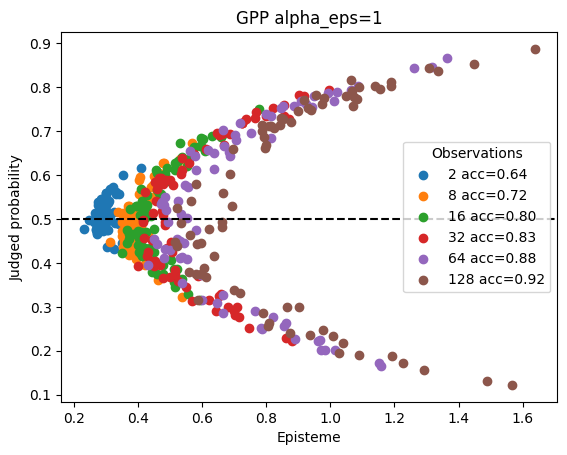

In [32]:
import math
import matplotlib.pyplot as plt

# Predefined colors
colors = [
    (0.53, 0.81, 0.92),  # Sky Blue
    (0.62, 0.85, 0.71),  # Mint Green
    (0.99, 0.69, 0.35),  # Sunset Orange
    (0.71, 0.53, 0.92),   # Lavender Purple
    (0.97, 0.51, 0.47) # Coral Pink

]

for groundtruth_prob in groundtruth_probs:
    for i in range(0,len(pos_nums)):
        #computing acc roc
        prediction = outputs_gpp_probability_dict[f"{groundtruth_prob}"][i]>0.5
        # acc = np.sum(y_query_posneg_binary==prediction)/len(y_query_posneg_binary)
        acc = sklearn.metrics.accuracy_score(y_query_posneg_binary, prediction)
        label = label=f'{pos_nums[i]} acc={acc:.2f}'
        auc = sklearn.metrics.roc_auc_score(y_query_posneg_binary,prediction)
        # label = label=f'{pos_nums[i]} auc={auc:.2f}'
        # plt.scatter(outputs_gpp_episteme[i], outputs_gpp_probability[i], color=colors[i], label=str(pos_nums[i])+" auc={:.2f}".format(auc))
        plt.scatter(outputs_gpp_episteme_dict[f"{groundtruth_prob}"][i], outputs_gpp_probability_dict[f"{groundtruth_prob}"][i], color=f'C{i}', label=label)
    plt.title(f'GPP alpha_eps={alpha_eps}')
    plt.xlabel('Episteme')
    # plt.ylim(-0.1,1.1)
    plt.axhline(y=0.5, ls='--', c='k', lw=1.5)
    # plt.xlim(0,1.7)
    plt.ylabel('Judged probability')
    plt.legend(title="Observations")
    plt.show()
    # plt.savefig(f'{save_pth}//gpp_epi_pro_sample_pos{groundtruth_prob}_e{alpha_eps}.png')  # Saves the plot as a PNG file
    plt.close()
    # print(f'{save_pth}//gpp_epi_pro_sample_pos{groundtruth_prob}_e{alpha_eps}.png')



## visualize LPE

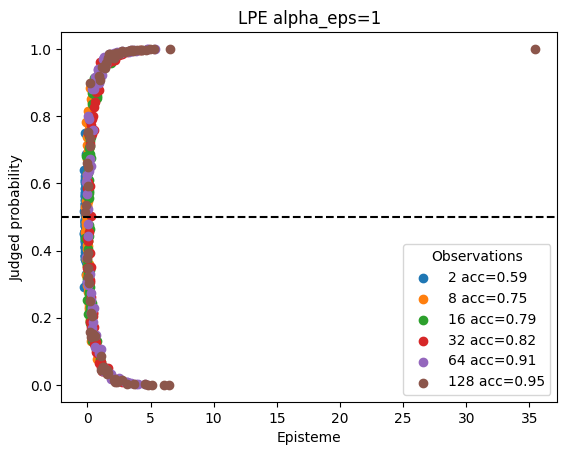

In [33]:
import math
import matplotlib.pyplot as plt

for groundtruth_prob in groundtruth_probs:
    for i in range(0,len(pos_nums)):
        #computing acc roc
        prediction = outputs_lpe_probability_dict[f"{groundtruth_prob}"][i]>0.5
        # acc = np.sum(y_query_posneg_binary==prediction)/len(y_query_posneg_binary)
        acc = sklearn.metrics.accuracy_score(y_query_posneg_binary, prediction)
        label = label=f'{pos_nums[i]} acc={acc:.2f}'
        auc = sklearn.metrics.roc_auc_score(y_query_posneg_binary,prediction)
        # label = label=f'{pos_nums[i]} auc={auc:.2f}'
        # plt.scatter(outputs_gpp_episteme[i], outputs_gpp_probability[i], color=colors[i], label=str(pos_nums[i])+" auc={:.2f}".format(auc))
        plt.scatter(outputs_lpe_episteme_dict[f"{groundtruth_prob}"][i], outputs_lpe_probability_dict[f"{groundtruth_prob}"][i], color=f'C{i}', label=label)
    plt.title(f'LPE alpha_eps={alpha_eps}')
    plt.xlabel('Episteme')
    # plt.ylim(-0.1,1.1)
    plt.axhline(y=0.5, ls='--', c='k', lw=1.5)
    # plt.xlim(0,1.7)
    plt.ylabel('Judged probability')
    plt.legend(title="Observations")
    plt.show()
    # plt.savefig(f'{save_pth}//lpe_epi_pro_sample_pos{groundtruth_prob}_e{alpha_eps}.png')  # Saves the plot as a PNG file
    plt.close()